# Expectaiton Maximization

## 1D Gaussian Mixture Model Implementation

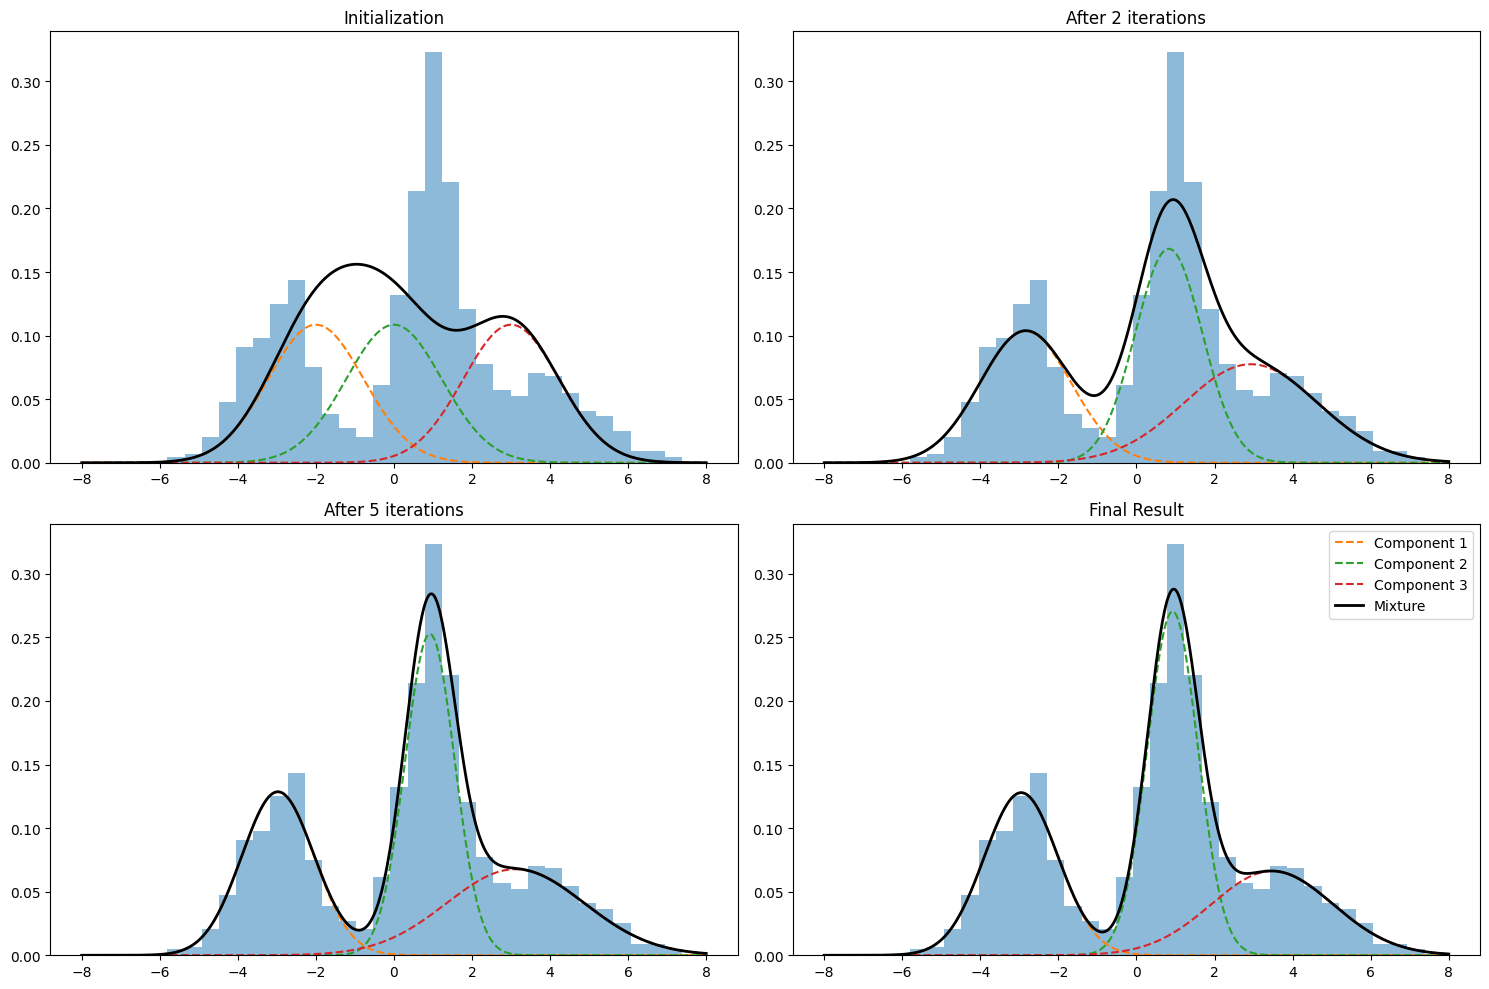

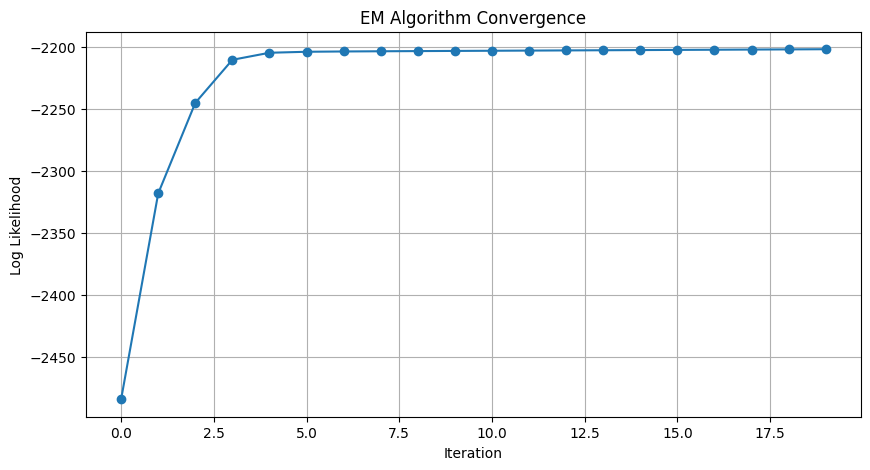

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set random seed for reproducibility
np.random.seed(0)

# Parameters
K = 3  # Number of Gaussian components
N = 1000  # Number of data points
max_iter = 20  # Maximum EM iterations

# True parameters for data generation
true_means = np.array([-3, 1, 4])
true_covariances = np.array([1, 0.5, 1.5])  # variances in 1D
true_pi = np.array([0.3, 0.5, 0.2])  # mixing coefficients

# Generate synthetic data
components = np.random.choice(K, size=N, p=true_pi)
data = np.array([np.random.normal(true_means[k], np.sqrt(true_covariances[k])) for k in components])

# Initialize parameters (purposely different from true values)
means = np.array([-2, 0, 3])  # means μ_k
covariances = np.array([1.5, 1.5, 1.5])  # σ_k^2
pi = np.ones(K)/K  # uniform initial weights

# Store history for visualization
history = {'means': [means.copy()], 
           'covariances': [covariances.copy()], 
           'pi': [pi.copy()],
           'log_likelihood': []}

# EM Algorithm
for iteration in range(max_iter):
    # E-step: Compute responsibilities γ(z_nk) - Equation 1
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * norm.pdf(data, means[k], np.sqrt(covariances[k]))
    gamma /= gamma.sum(axis=1, keepdims=True)  # normalize
    
    # M-step: Update parameters - Equations 2-5
    Nk = gamma.sum(axis=0)  # Equation 5
    
    # Update means - Equation 2
    new_means = np.array([np.sum(gamma[:, k] * data) / Nk[k] for k in range(K)])
    
    # Update covariances - Equation 3 (simplified for 1D)
    new_covariances = np.array([np.sum(gamma[:, k] * (data - new_means[k])**2) / Nk[k] for k in range(K)])
    
    # Update mixing coefficients - Equation 4
    new_pi = Nk / N
    
    # Compute log likelihood - Equation 6
    log_likelihood = np.sum([np.log(np.sum([pi[k] * norm.pdf(x, means[k], np.sqrt(covariances[k])) 
                                          for k in range(K)])) for x in data])
    
    # Store current parameters
    history['means'].append(new_means.copy())
    history['covariances'].append(new_covariances.copy())
    history['pi'].append(new_pi.copy())
    history['log_likelihood'].append(log_likelihood)
    
    # Update parameters for next iteration
    means, covariances, pi = new_means, new_covariances, new_pi

# Visualization
plt.figure(figsize=(15, 10))

# Plot initialization
plt.subplot(2, 2, 1)
x_grid = np.linspace(-8, 8, 1000)
init_means = history['means'][0]
init_covs = history['covariances'][0]
init_pi = history['pi'][0]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = init_pi[k] * norm.pdf(x_grid, init_means[k], np.sqrt(init_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('Initialization')

# Plot after 2 iterations
plt.subplot(2, 2, 2)
iter2_means = history['means'][2]
iter2_covs = history['covariances'][2]
iter2_pi = history['pi'][2]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = iter2_pi[k] * norm.pdf(x_grid, iter2_means[k], np.sqrt(iter2_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('After 2 iterations')

# Plot after 5 iterations
plt.subplot(2, 2, 3)
iter5_means = history['means'][5]
iter5_covs = history['covariances'][5]
iter5_pi = history['pi'][5]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = iter5_pi[k] * norm.pdf(x_grid, iter5_means[k], np.sqrt(iter5_covs[k]))
    plt.plot(x_grid, component, '--')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2)
plt.title('After 5 iterations')

# Plot final result
plt.subplot(2, 2, 4)
final_means = history['means'][-1]
final_covs = history['covariances'][-1]
final_pi = history['pi'][-1]

plt.hist(data, bins=30, density=True, alpha=0.5)
pdf = np.zeros_like(x_grid)
for k in range(K):
    component = final_pi[k] * norm.pdf(x_grid, final_means[k], np.sqrt(final_covs[k]))
    plt.plot(x_grid, component, '--', label=f'Component {k+1}')
    pdf += component
plt.plot(x_grid, pdf, 'k-', linewidth=2, label='Mixture')
plt.title('Final Result')
#sorry keene idk why the legend only shows in the bottom left histogram. idk how to fix it
plt.legend()

plt.tight_layout()
plt.show()

# Plot log likelihood
plt.figure(figsize=(10, 5))
plt.plot(history['log_likelihood'], 'o-')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('EM Algorithm Convergence')
plt.grid(True)
plt.show()

# 2D EM (Image 9.8 replication)

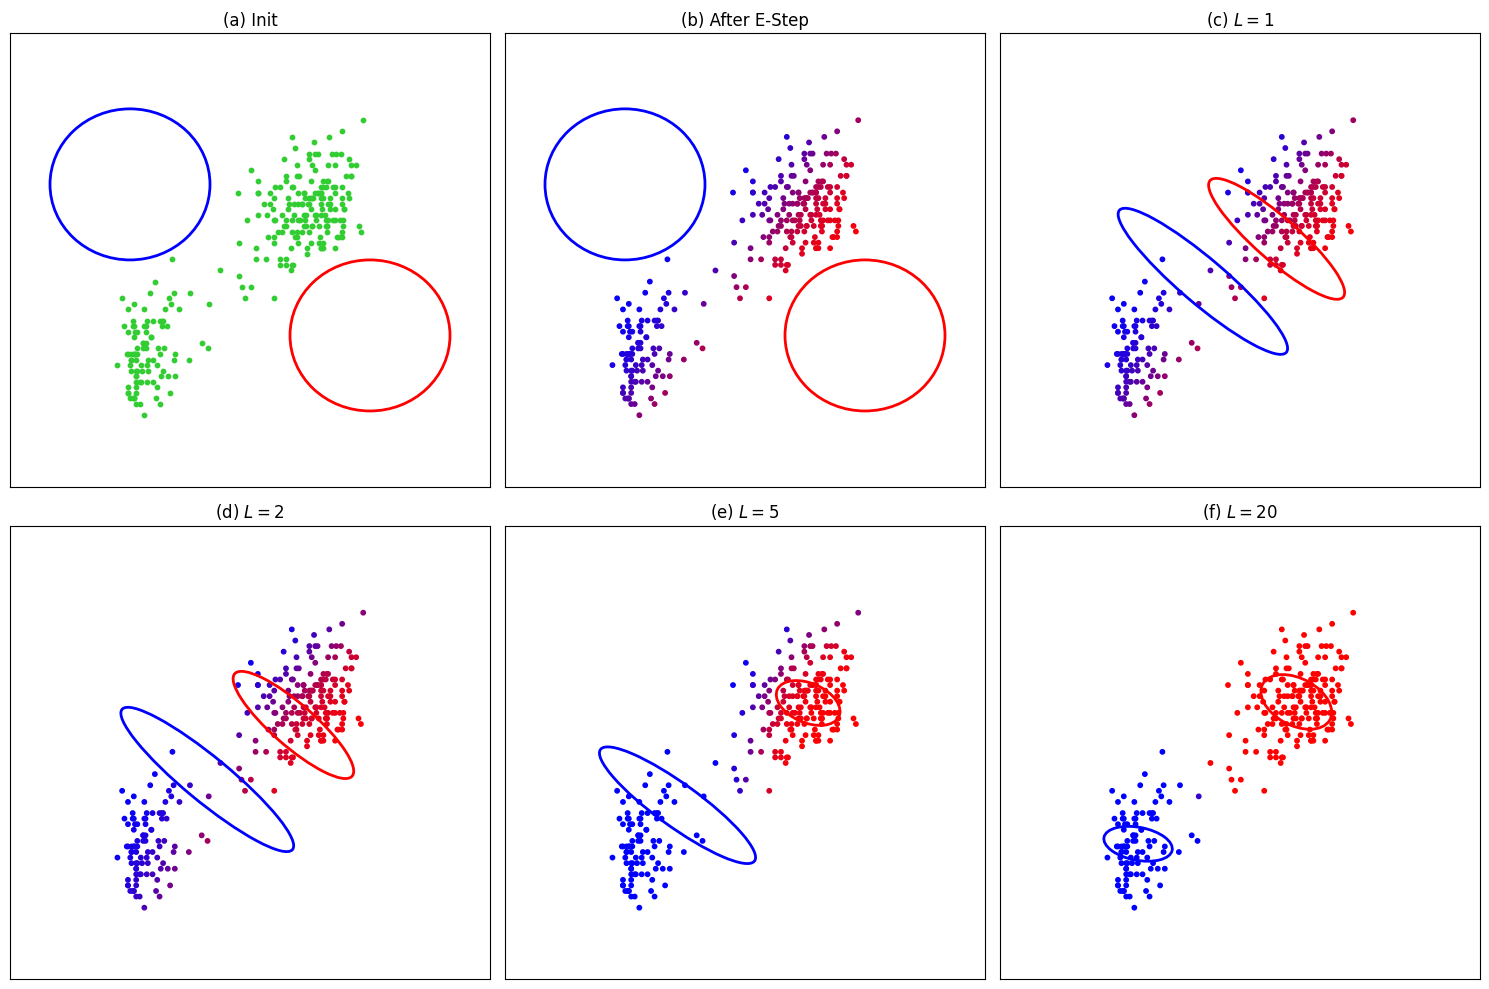

In [9]:
import pandas as pd
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

# Load and standardize Old Faithful dataset
url = "https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat"
faithful = pd.read_csv(url, sep='\\s+', skiprows=25)
X = faithful[['eruptions', 'waiting']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Parameters
K = 2
N, D = X.shape
max_iter = 20

# Initialization
means = np.array([[-1.5, 1.0], [1.5, -1.0]])  # Fixed init similar to Bishop
covariances = [np.eye(D) for _ in range(K)]
weights = np.ones(K) / K  # uniform mixing

# History for visualization
history_2d = {
    'means': [means.copy()],
    'covariances': [covariances.copy()],
    'weights': [weights.copy()],
    'responsibilities': []
}

# EM Algorithm
for iteration in range(max_iter):
    # expectation step
    responsibilities = np.zeros((N, K))
    for k in range(K):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    
    # maximizzation step
    Nk = responsibilities.sum(axis=0)
    weights = Nk / N
    means = np.dot(responsibilities.T, X) / Nk[:, None]
    covariances = []
    for k in range(K):
        diff = X - means[k]
        cov_k = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
        covariances.append(cov_k)

    # Save history
    history_2d['means'].append(means.copy())
    history_2d['covariances'].append([c.copy() for c in covariances])
    history_2d['weights'].append(weights.copy())
    history_2d['responsibilities'].append(responsibilities.copy())

# Image 9.8 replication
def draw_ellipse(mean, cov, ax, color, alpha=1.0):
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
    width, height = 2 * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=color, fc='None', lw=2, alpha=alpha)
    ax.add_patch(ellipse)

steps_to_plot = [0, 1, 2, 5, 20]  # iterations
titles = ["(a) Init", "(b) After E-Step", r"(c) $L=1$", r"(d) $L=2$", r"(e) $L=5$", r"(f) $L=20$"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, step in enumerate([0, 0, 1, 2, 5, 20]):
    ax = axes[i]
    if step == 0 and i == 0:
        # Initialization
        ax.scatter(X[:, 0], X[:, 1], color='limegreen', s=10)
        for k in range(K):
            draw_ellipse(history_2d['means'][0][k], np.eye(D), ax, color='blue' if k == 0 else 'red')
    elif step == 0 and i == 1:
        # After E-step
        R = history_2d['responsibilities'][0]
        color_mix = R @ np.array([[0, 0, 1], [1, 0, 0]])
        ax.scatter(X[:, 0], X[:, 1], color=color_mix, s=10)
        for k in range(K):
            draw_ellipse(history_2d['means'][0][k], np.eye(D), ax, color='blue' if k == 0 else 'red')
    else:
        R = history_2d['responsibilities'][step-1]
        color_mix = R @ np.array([[0, 0, 1], [1, 0, 0]])
        ax.scatter(X[:, 0], X[:, 1], color=color_mix, s=10)
        for k in range(K):
            draw_ellipse(history_2d['means'][step][k],
                         history_2d['covariances'][step][k],
                         ax, color='blue' if k == 0 else 'red')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
